In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda, Flatten, Reshape,MaxPooling1D,Dropout
from keras.layers import Conv1D,UpSampling1D
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
from keras.datasets import mnist
import pandas as pd
import numpy as np
from keras.datasets import mnist

original_dim = 44100
intermediate_dim = 128
latent_dim = 20
batch_size = 42
epochs = 20
epsilon_std = 1.0

x_train = np.load('train_data.npy')
y_train = pd.read_csv('train_labels.csv')
y_train = np.array(y_train)
y_train = y_train[:,1]

x_train = x_train.astype('float32')

# # normalization
normalizer = Normalizer().fit(x_train)
x_train = normalizer.transform(x_train)

# reshape
x_train = x_train.reshape(-1,original_dim,1)

# train and validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2,train_size=0.8,random_state=42)

print(x_train.shape,x_val.shape)

(3199, 44100, 1) (800, 44100, 1)


In [3]:
x = Input(shape=(x_train.shape[1],1)) 
x.reshape=(1,44100)

conv_1 = Conv1D(32,
                kernel_size=5, 
                activation='relu',
                input_shape=(x_train.shape[1],1))(x)
conv_1_maxpooling=MaxPooling1D(pool_size=2,strides=10)(conv_1)

conv_2 = Conv1D(64,
                kernel_size=5, 
                activation='relu')(conv_1_maxpooling)
conv_2_maxpooling=MaxPooling1D(pool_size=50,strides=10)(conv_2)

flat = Flatten()(conv_2_maxpooling) 
hidden = Dense(intermediate_dim, activation='relu')(flat)
hidden_dropout = Dropout(0.5)(hidden)
z_mean = Dense(latent_dim)(hidden_dropout)
z_log_var = Dense(latent_dim)(hidden)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim))
    return z_mean + K.exp(z_log_var ) * epsilon 

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

W0927 02:08:10.939479  9852 deprecation_wrapper.py:119] From C:\Users\admin\Anaconda4\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0927 02:08:10.975900  9852 deprecation_wrapper.py:119] From C:\Users\admin\Anaconda4\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0927 02:08:10.983873  9852 deprecation_wrapper.py:119] From C:\Users\admin\Anaconda4\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0927 02:08:11.026762  9852 deprecation_wrapper.py:119] From C:\Users\admin\Anaconda4\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0927 02:08:11.

In [4]:
encoder = Model(x, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 44100, 1)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 44096, 32)    192         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 4410, 32)     0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 4406, 64)     10304       max_pooling1d_1[0][0]            
____________________________________________________________________________________________

In [5]:
latent_inputs = Input(shape=(latent_dim,))
decoder_h = Dense(intermediate_dim, activation='relu')(latent_inputs)
decoder_mean = Dense(original_dim, activation='sigmoid')(decoder_h)
x_decoded_mean = Reshape([original_dim,1])(decoder_mean)

# instantiate decoder model
decoder = Model(latent_inputs, x_decoded_mean, name='decoder')
decoder.summary()

x_decoded_mean = decoder(encoder(x)[2])


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               2688      
_________________________________________________________________
dense_5 (Dense)              (None, 44100)             5688900   
_________________________________________________________________
reshape_1 (Reshape)          (None, 44100, 1)          0         
Total params: 5,691,588
Trainable params: 5,691,588
Non-trainable params: 0
_________________________________________________________________


In [6]:
def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # Double check wtf this is supposed to be
    xent_loss = K.mean(xent_loss)
    return xent_loss + kl_loss

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='adam', loss=vae_loss) # 'rmsprop'
vae.summary()

W0927 02:08:11.516452  9852 deprecation_wrapper.py:119] From C:\Users\admin\Anaconda4\envs\tensorflow\lib\site-packages\keras\optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0927 02:08:11.576345  9852 deprecation.py:323] From C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 44100, 1)          0         
_________________________________________________________________
encoder (Model)              [(None, 20), (None, 20),  3587496   
_________________________________________________________________
decoder (Model)              (None, 44100, 1)          5691588   
Total params: 9,279,084
Trainable params: 9,279,084
Non-trainable params: 0
_________________________________________________________________


In [7]:
print(x_val.shape)
print(x_train.shape)
print(x_decoded_mean.shape)
print(x.shape)


(800, 44100, 1)
(3199, 44100, 1)
(42, 44100, 1)
(?, 44100, 1)


Train on 3192 samples, validate on 798 samples
Epoch 1/20
3192/3192 [==============================] - 167s 52ms/step - loss: 3634.8436 - val_loss: 134.9785
Epoch 2/20
3192/3192 [==============================] - 175s 55ms/step - loss: 139.4962 - val_loss: 102.5886
Epoch 3/20
3192/3192 [==============================] - 207s 65ms/step - loss: 112.4163 - val_loss: 87.2268
Epoch 4/20
3192/3192 [==============================] - 252s 79ms/step - loss: 92.8989 - val_loss: 82.1261
Epoch 5/20
3192/3192 [==============================] - 195s 61ms/step - loss: 78.1167 - val_loss: 61.3885
Epoch 6/20
3192/3192 [==============================] - 194s 61ms/step - loss: 68.2706 - val_loss: 56.6482
Epoch 7/20
3192/3192 [==============================] - 193s 61ms/step - loss: 62.6515 - val_loss: 50.1120
Epoch 8/20
3192/3192 [==============================] - 180s 56ms/step - loss: 54.9231 - val_loss: 43.0624
Epoch 9/20
3192/3192 [==============================] - 192s 60ms/step - loss: 49.6557 - va

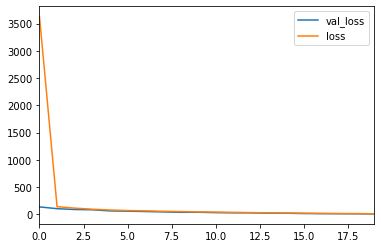

In [8]:
hist=vae.fit(x_train[:3192,:], x_train[:3192,:],
             shuffle=False,
             epochs=20,
             batch_size=batch_size,
             validation_data=(x_val[:798,:],x_val[:798,:]))

pd.DataFrame(hist.history).plot()

In [9]:
encoder = Model(x, z_mean)
z_test = encoder.predict(x_train, batch_size=batch_size)
print(z_test.shape)

(3199, 20)


In [10]:
#decoder = Model(latent_inputs,x_decoded_mean)

pred_train = decoder.predict(z_test)
decoded_train = pred_train.reshape(3199,44100)
x_test = x_val.reshape(800,44100)
y_test = y_val.reshape(800,1)
print(decoded_train.shape)
print(x_test.shape)
print(y_test.shape)

(3199, 44100)
(800, 44100)
(800, 1)


In [11]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

# random forest model creation
rfc = RandomForestClassifier()
rfc.fit(decoded_train,y_train)
# predictions
rfc_predict = rfc.predict(x_test)
print(rfc_predict.shape)

C:\Users\admin\Anaconda4\envs\tensorflow\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(800,)


In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
#y_test=y_test.reshape(800,1)
rfc_cv_score = cross_val_score(rfc, y_test, rfc_predict)
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[ 90 612]
 [ 11  87]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.89      0.13      0.22       702
           1       0.12      0.89      0.22        98

    accuracy                           0.22       800
   macro avg       0.51      0.51      0.22       800
weighted avg       0.80      0.22      0.22       800



=== All AUC Scores ===
[0.87265918 0.87265918 0.87593985]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.8737527338946617


C:\Users\admin\Anaconda4\envs\tensorflow\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\admin\Anaconda4\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\admin\Anaconda4\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\admin\Anaconda4\envs\tensorflow\lib\site-packages\sklearn\model_selection\_validation.py:516: DataConversionWa

In [ ]:
#20 --- 0.87
#10 --- 0.70
#50 --- 0.59